In [1]:
!pip install -q -U tfds-nightly

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import matplotlib as mpl
import matplotlib.pyplot as plt

tf.random.set_seed(42)

# Etude 1 - Building a Simple CNN

Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.

In [3]:
EPOCHS_N = 50
BATCH_SIZE = 32

In [4]:
mnist, mnist_info = tfds.load("mnist:3.*.*", with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
mnist_info.splits

{'test': <tfds.core.SplitInfo num_examples=10000>,
 'train': <tfds.core.SplitInfo num_examples=60000>}

In [6]:
mnist_test = tfds.load("mnist:3.*.*", as_supervised=True, split='test') 
mnist_train = tfds.load("mnist:3.*.*", as_supervised=True, split='train[:50000]') 
mnist_valid = tfds.load("mnist:3.*.*", as_supervised=True, split='train[50000:]')

Let's calculate the length of the datasets.

In [7]:
def calculate_dataset_size(dataset):
    """Returns the dataset length."""
    item_count = 0
    for item in dataset:
        item_count += 1
    return item_count

In [8]:
test_size = calculate_dataset_size(mnist_test)
train_size = calculate_dataset_size(mnist_train)
validation_size = calculate_dataset_size(mnist_valid)

Let's prepare the datasets:

In [9]:
mnist_test = mnist_test.cache().map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE)
mnist_train = mnist_train.cache().map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).shuffle(1000).repeat().batch(BATCH_SIZE)
mnist_valid = mnist_valid.cache().map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE)

Let's build the CNN model.

In [10]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [11]:
model_v1 = keras.models.Sequential()
model_v1.add(keras.layers.Conv2D(filters=128, kernel_size=4, strides=1, padding="same", input_shape=(28,28,1), activation='relu'))
model_v1.add(keras.layers.MaxPool2D(2))
model_v1.add(keras.layers.SpatialDropout2D(0.5))
model_v1.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation='relu'))
model_v1.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=1, padding="same", activation='relu'))
model_v1.add(keras.layers.MaxPool2D(2))
model_v1.add(keras.layers.SpatialDropout2D(0.5))
model_v1.add(keras.layers.Conv2D(filters=256, kernel_size=2, strides=1, padding="same", activation='relu'))
model_v1.add(keras.layers.Conv2D(filters=256, kernel_size=2, strides=2, padding="same", activation='relu'))
model_v1.add(keras.layers.Flatten())
model_v1.add(keras.layers.Dense(units=10, activation='softmax'))

model_v1.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model_v1.fit(mnist_train, epochs=EPOCHS_N, validation_data=mnist_valid, steps_per_epoch=int(train_size / BATCH_SIZE), 
             validation_steps=int(validation_size / BATCH_SIZE),
             callbacks=[early_stopping_cb])

Epoch 1/50
1562/1562 [==============================] - 12s 7ms/step - loss: 0.1667 - accuracy: 0.9480 - val_loss: 0.0788 - val_accuracy: 0.9775
Epoch 2/50
1562/1562 [==============================] - 11s 7ms/step - loss: 0.0715 - accuracy: 0.9781 - val_loss: 0.0569 - val_accuracy: 0.9834
Epoch 3/50
1562/1562 [==============================] - 11s 7ms/step - loss: 0.0568 - accuracy: 0.9837 - val_loss: 0.0721 - val_accuracy: 0.9832
Epoch 4/50
1562/1562 [==============================] - 11s 7ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.0458 - val_accuracy: 0.9881
Epoch 5/50
1562/1562 [==============================] - 11s 7ms/step - loss: 0.0419 - accuracy: 0.9874 - val_loss: 0.0479 - val_accuracy: 0.9874
Epoch 6/50
1562/1562 [==============================] - 11s 7ms/step - loss: 0.0393 - accuracy: 0.9881 - val_loss: 0.0567 - val_accuracy: 0.9858
Epoch 7/50
1562/1562 [==============================] - 11s 7ms/step - loss: 0.0356 - accuracy: 0.9892 - val_loss: 0.0400 - val_ac

In [12]:
model_v1.evaluate(mnist_test, steps=int(test_size / BATCH_SIZE))

312/312 [==============================] - 1s 3ms/step - loss: 0.0331 - accuracy: 0.9915


[0.03312494605779648, 0.9914863705635071]

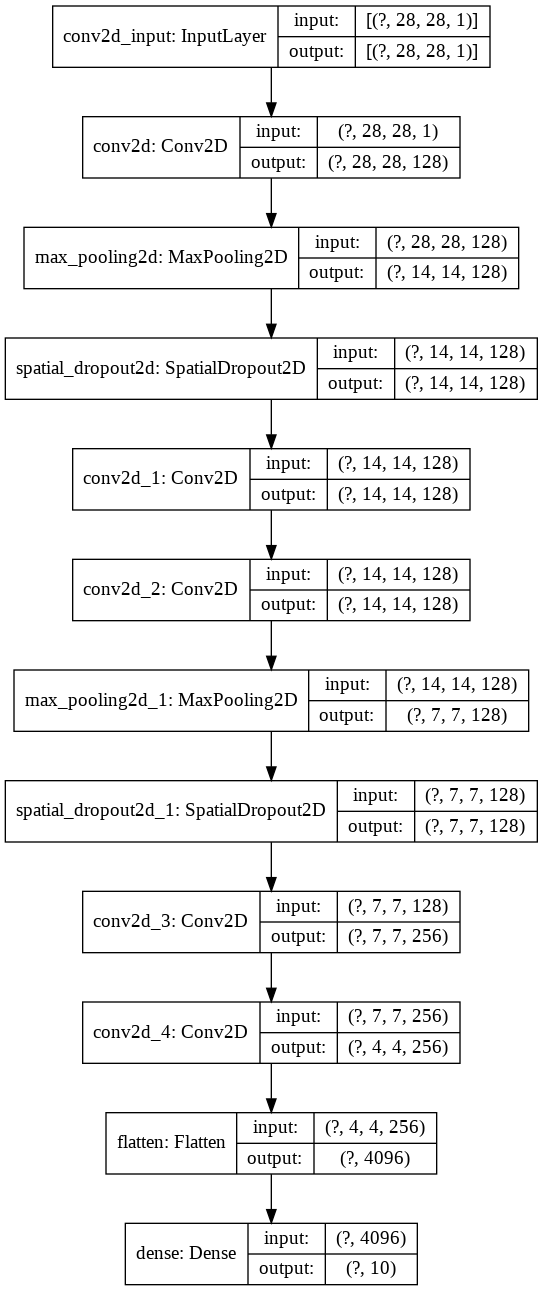

In [13]:
keras.utils.plot_model(model_v1, show_shapes=True)

# Etude 2 - Using a Transfer Learning for Image Classification

Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can just use an existing dataset (e.g., from TensorFlow Datasets).

In [14]:
dataset, dataset_info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [15]:
dataset_info.splits

{'test': <tfds.core.SplitInfo num_examples=3669>,
 'train': <tfds.core.SplitInfo num_examples=3680>}

In [16]:
class_names = dataset_info.features['label'].names

Split it into a training set, a validation set and a test set.

In [17]:
dataset_train = tfds.load("oxford_iiit_pet:3.*.*", as_supervised=True, split='train')
dataset_valid = tfds.load("oxford_iiit_pet:3.*.*", as_supervised=True, split='test[3200:]')
dataset_test = tfds.load("oxford_iiit_pet:3.*.*", as_supervised=True, split='test[:3200]')

In [18]:
# lenghts of the datasets

dataset_test_size = calculate_dataset_size(dataset_test)
dataset_train_size = calculate_dataset_size(dataset_train)
dataset_validation_size = calculate_dataset_size(dataset_valid)

Let's view some random images from the dataset.

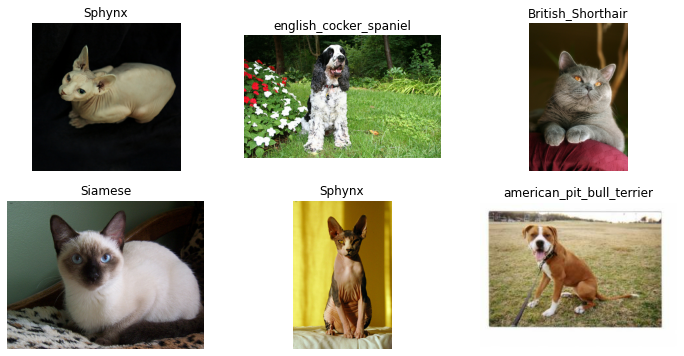

In [19]:
plt.figure(figsize=(12, 6))
index = 0

for image, label in dataset_train.take(6):
    index += 1
    plt.subplot(2, 3, index)
    plt.imshow(image)
    plt.title(f"{class_names[label]}")
    plt.axis("off")

plt.show()

Let's view the dimensions of some images from the dataset.

In [20]:
for image, label in dataset_train.take(6):
    print(image.shape, label)

(500, 500, 3) tf.Tensor(33, shape=(), dtype=int64)
(313, 500, 3) tf.Tensor(12, shape=(), dtype=int64)
(500, 333, 3) tf.Tensor(9, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(32, shape=(), dtype=int64)
(500, 333, 3) tf.Tensor(33, shape=(), dtype=int64)
(219, 300, 3) tf.Tensor(2, shape=(), dtype=int64)


Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.

In [21]:
TARGET_IMAGE_W = TARGET_IMAGE_H = 299

def resize_preserving_ratio(image):
    """Resizes the image while preserving the aspect ratio."""
    resized_image = tf.image.resize_with_crop_or_pad(image, TARGET_IMAGE_H, TARGET_IMAGE_W)
    return resized_image

def resize_image(image):
    """Resizes the image without preserving the aspect ratio."""
    resized_image = tf.image.resize(image, [TARGET_IMAGE_H, TARGET_IMAGE_W])
    return resized_image

def normalize_image(image):
    """Normlizes the image."""
    normalized_image = tf.cast(image, tf.float32) / 255.0
    return normalized_image

def random_flip(image):
    """Randomly flips the image."""
    randomly_flipped = tf.image.random_flip_left_right(image)
    return randomly_flipped

def preprocess_image(image, label):
    """Perfors image resize, normalization and flip."""
    # leads to lower accuracy than resize_image()
    # resized_image = resize_preserving_ratio(image) 
    resized_image = resize_image(image)
    resized_normalized_image = normalize_image(resized_image)
    flipped = random_flip(resized_normalized_image)
    return flipped, label

In [22]:
dataset_test = dataset_test.map(preprocess_image).batch(BATCH_SIZE)
dataset_train = dataset_train.map(preprocess_image).shuffle(1000).repeat().batch(BATCH_SIZE)
dataset_valid = dataset_valid.map(preprocess_image).batch(BATCH_SIZE)

Fine-tune a pretrained model on this dataset.

In [23]:
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg')
predictions = keras.layers.Dense(units=len(class_names), activation='softmax')(base_model.output)

final_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

219062272/219055592 [==============================] - 1s 0us/step


In [24]:
base_model.trainable = False

In [25]:
final_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01), metrics=["accuracy"])
final_model.fit(dataset_train, epochs=EPOCHS_N, validation_data=dataset_valid, steps_per_epoch=int(dataset_train_size / BATCH_SIZE), 
                validation_steps=int(dataset_validation_size / BATCH_SIZE),
                callbacks=[early_stopping_cb])

Epoch 1/50
115/115 [==============================] - 37s 326ms/step - loss: 1.0750 - accuracy: 0.7989 - val_loss: 0.6446 - val_accuracy: 0.8817
Epoch 2/50
115/115 [==============================] - 35s 304ms/step - loss: 0.3526 - accuracy: 0.9215 - val_loss: 0.3823 - val_accuracy: 0.9129
Epoch 3/50
115/115 [==============================] - 35s 304ms/step - loss: 0.1959 - accuracy: 0.9418 - val_loss: 0.3755 - val_accuracy: 0.9107
Epoch 4/50
115/115 [==============================] - 35s 304ms/step - loss: 0.1334 - accuracy: 0.9549 - val_loss: 0.3354 - val_accuracy: 0.9308
Epoch 5/50
115/115 [==============================] - 35s 301ms/step - loss: 0.1063 - accuracy: 0.9641 - val_loss: 0.3382 - val_accuracy: 0.9308
Epoch 6/50
115/115 [==============================] - 35s 303ms/step - loss: 0.0871 - accuracy: 0.9666 - val_loss: 0.3077 - val_accuracy: 0.9286
Epoch 7/50
115/115 [==============================] - 35s 305ms/step - loss: 0.0747 - accuracy: 0.9745 - val_loss: 0.2996 - val_ac

In [26]:
base_model.trainable = True

In [27]:
reducelr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [28]:
final_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001), metrics=["accuracy"])

final_model.fit(dataset_train, epochs=EPOCHS_N, validation_data=dataset_valid, steps_per_epoch=int(dataset_train_size / BATCH_SIZE), 
              validation_steps=int(dataset_validation_size / BATCH_SIZE), callbacks = [reducelr_cb, early_stopping_cb])

Epoch 1/50
115/115 [==============================] - 81s 703ms/step - loss: 0.5247 - accuracy: 0.8481 - val_loss: 0.8508 - val_accuracy: 0.7879
Epoch 2/50
115/115 [==============================] - 78s 683ms/step - loss: 0.1150 - accuracy: 0.9644 - val_loss: 0.4046 - val_accuracy: 0.8973
Epoch 3/50
115/115 [==============================] - 78s 682ms/step - loss: 0.0314 - accuracy: 0.9899 - val_loss: 0.2987 - val_accuracy: 0.9152
Epoch 4/50
115/115 [==============================] - 78s 683ms/step - loss: 0.0152 - accuracy: 0.9965 - val_loss: 0.2409 - val_accuracy: 0.9308
Epoch 5/50
115/115 [==============================] - 78s 679ms/step - loss: 0.0117 - accuracy: 0.9973 - val_loss: 0.2798 - val_accuracy: 0.9263
Epoch 6/50
115/115 [==============================] - 78s 679ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.2577 - val_accuracy: 0.9219
Epoch 7/50
115/115 [==============================] - 78s 680ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.2633 - val_ac

In [29]:
final_model.evaluate(dataset_test, steps=int(dataset_test_size / BATCH_SIZE))

100/100 [==============================] - 18s 183ms/step - loss: 0.3544 - accuracy: 0.9109


[0.35440462827682495, 0.910937488079071]